In [1]:
!pip install transformers
import pandas as pd
import nltk
from tqdm.notebook import tqdm
tqdm.pandas()

# Load Readability data

In [2]:
# For Google Colab
#from google.colab import drive
#drive.mount('/content/drive')
#df_readability_kickstarter_small = pd.read_csv('./kickstarter_readability_small.csv')
#df_readability_kickstarter = pd.read_csv('../datasets/kickstarter_cleaned/kickstarter_cleaned_topicmodelling.csv')
df_progess = pd.read_csv('./progress.csv')

In [19]:
df_progess.to_csv('./progress.csv')

In [10]:
print(len(df_readability_kickstarter.index))

356108


In [11]:
df_progess['bert_score'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 356108 entries, 0 to 356107
Series name: bert_score
Non-Null Count   Dtype  
--------------   -----  
356108 non-null  float64
dtypes: float64(1)
memory usage: 2.7 MB


In [15]:
df_progess.iloc[335000:].head(10) # 220000 # 260000
#print(len(df_progess.iloc[90000:].index))

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,project_id,project_url,project_video_url,project_title,project_blurb,...,project_rewards,project_launched_at,project_successful_at,project_deadline,project_staff_pick,project_creator_project_number,project_description,num_words,project_lang,bert_score
335000,335000,335000,335000,335000,532524,1037836815,https://www.kickstarter.com/projects/sonnyloui...,https://v.kickstarter.com/1638567683_76a284b2f...,A Woman of Mystery,This crime drama is about a strange woman sear...,...,8,2021-10-01 19:48:04,NaN,2021-11-30 19:48:04,0,1.0,The strongest woman character is a mother. I w...,172.0,en,9.374911
335001,335001,335001,335001,335001,532525,1481474055,https://www.kickstarter.com/projects/landbetwe...,NaN,Growing Houma Tribal Educational Resources,This project will print educational books and ...,...,7,2021-11-01 08:09:30,2021-12-01 06:59:00,2021-12-01 06:59:00,0,1.0,Usápuse' Yákani' Ékelanna' (“Land between Two ...,306.0,en,23.970716
335002,335002,335002,335002,335002,532526,1195820857,https://www.kickstarter.com/projects/sculpting...,NaN,Animal Crossing themed acrylic pins (Canceled),Acrylic pins themed around Animal Crossing New...,...,13,2021-10-31 21:50:39,NaN,2021-11-30 22:50:39,0,2.0,"Hi, I'm Tara one of the owners of Marshmallow ...",386.0,en,15.253765
335003,335003,335003,335003,335003,532531,1628899670,https://www.kickstarter.com/projects/thegoldci...,NaN,Bringing out “Big Mamma”,Raising funds for A 220 plug so that we can us...,...,1,2021-11-01 21:21:21,NaN,2021-12-01 22:21:21,0,1.0,Moon-phase gold and holographic cauldron from ...,462.0,en,26.847332
335004,335004,335004,335004,335004,532532,1336731553,https://www.kickstarter.com/projects/132718528...,NaN,Help Excel Media grow,"Custom made hand drawn t-shirts, hoodies and m...",...,3,2021-10-02 09:05:20,NaN,2021-12-01 09:05:20,0,1.0,My name is James Warmack. I am a single father...,144.0,en,7.273710
335005,335005,335005,335005,335005,532537,2082172105,https://www.kickstarter.com/projects/henrymart...,https://v.kickstarter.com/1638610643_3e058a394...,Fireworks Safety,I have a fireworks safety platform that will h...,...,5,2021-11-03 16:14:36,NaN,2021-12-01 06:59:00,0,1.0,My name is Henry Martin and I am the creator o...,555.0,en,6.505554
335006,335006,335006,335006,335006,532539,1926345543,https://www.kickstarter.com/projects/fluxfall/...,https://v.kickstarter.com/1638544604_47efc64d2...,Fluxfall Horizon,A fast and light RPG about players who jump fr...,...,8,2021-11-01 13:20:05,2021-12-01 14:20:05,2021-12-01 14:20:05,0,1.0,What is Fluxfall Horizon? \n\nFluxfall Horizon...,2883.0,en,18.613581
335007,335007,335007,335007,335007,532540,1094094097,https://www.kickstarter.com/projects/thetwiste...,NaN,Decorated Decay by The Twisted Pixie,My debut enamel pin collection,...,5,2021-10-05 05:24:41,NaN,2021-12-01 05:59:00,0,1.0,"Decorated Decay, showing beauty in death.\n\nW...",449.0,en,18.059997
335008,335008,335008,335008,335008,532544,529885845,https://www.kickstarter.com/projects/doublesho...,https://v.kickstarter.com/1638593939_35b494a59...,Silver Sable: Pride Animation Film,This will be an animated short about Marvel&#3...,...,3,2021-11-02 03:09:14,2021-12-02 04:09:14,2021-12-02 04:09:14,0,5.0,Silver Sable (Silver Sablinova) is a fictional...,348.0,en,7.248793
335009,335009,335009,335009,335009,532545,1386528025,https://www.kickstarter.com/projects/nihmory/n...,https://v.kickstarter.com/1638563516_617dcf2d1...,Nihmory (Canceled),Uncover the buried mysteries of Nihmory and sa...,...,9,2021-11-02 04:08:01,NaN,2021-12-02 05:08:01,0,1.0,Uncover the buried mysteries of Nihmory and sa...,938.0,en,16.203668


## Calculate BERT PPL Score

In [6]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
import torch
import numpy as np

model_name = 'bert-base-uncased'
model = AutoModelForMaskedLM.from_pretrained(model_name, torch_dtype=torch.float16)
model.cuda().half()
model.eval()
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
def score(model, tokenizer, sentence):
    #print(torch.cuda.memory_allocated() // 1024 ** 2)
    with torch.no_grad():
        tensor_input = tokenizer.encode(sentence, return_tensors='pt')
        
        # Check if the tokenized input exceeds GPU RAM limit
        if tensor_input.size(-1) > 256:
            # Truncate the sentence to a maximum length
            tensor_input = tensor_input[:, :256]
            
        #print(tensor_input.size())
        repeat_input = tensor_input.repeat(tensor_input.size(-1)-2, 1)
        mask = torch.ones(tensor_input.size(-1) - 1).diag(1)[:-2]
        masked_input = repeat_input.masked_fill(mask == 1, tokenizer.mask_token_id)
        #print(masked_input.size())
        labels = repeat_input.masked_fill( masked_input != tokenizer.mask_token_id, -100)
    
        # Send masked_input and labels to the GPU
        masked_input = masked_input.cuda()
        labels = labels.cuda()
        
        #print(torch.cuda.memory_allocated() // 1024 ** 2)
        
        with torch.inference_mode():
            loss = model(masked_input, labels=labels).loss
    
        #print(torch.cuda.memory_allocated() // 1024 ** 2)
        
        bert_score = np.exp(loss.item())
    
        # Delete intermediate tensors
        masked_input = None
        labels = None
        del tensor_input, repeat_input, mask, masked_input, labels, loss
        
        #print(torch.cuda.memory_allocated() // 1024 ** 2)
        
        return bert_score

In [ ]:
print(model)

In [ ]:
score(model, tokenizer, "How do you like me? Do you love me? How do you like me? Do you love me? How do you like me? Do you love me? How do you like me? Do you love me? How do you like me? Do you love me? How do you like me? Do you love me? How do you like me? Do you love me? How do you like me? Do you love me? How do you like me? Do you love me? How do you like me? Do you love me? How do you like me? Do you loveadad me? How do you like me? Do you love me? How do you like me? Do you love me? How do you like madaadddadadae? Do you laadadaove me? How do you like me? Do you love me? How do you like me? Do you love me? How do you like me? Do you love me? How do you like me? Do you love me? How do you like me? Do you love me? How do you like me? Do you love me? How do you like me? Do you love me? How do you like me? Do you love me? How do you like me? Do jfoqfjfj love me? Hello Hello Hello Yallah Hehehea Bruuh Jones BBQ foot massage")

In [8]:
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

#def score_corpus(corpus):
    #sentences = sent_tokenize(corpus)
    #batch_size = 1  # Adjust batch size according to your GPU memory
    
    #scores = []
    #for i in range(0, len(sentences), batch_size):
    #    batch_sentences = sentences[i:i + batch_size]
        
    #    with torch.inference_mode():
    #        batch_scores = [score(model, tokenizer, sentence) for sentence in batch_sentences]
        
    #    batch_sentences = None
    #    del batch_sentences
        
    #    scores.extend(batch_scores)
        
        # Clear GPU memory after each batch
    #    torch.cuda.empty_cache()
    
    # mean = geo_mean(scores)
    
    # Delete intermediate Tensors
    # del scores
    
    #return mean
    
def score_corpus(corpus):
    sentences = sent_tokenize(corpus)
    scores = []
    for sentence in sentences:
        #print(sentence)
        bert_score = score(model, tokenizer, sentence)
        #print(bert_score)
        scores.append(bert_score)
        
        del bert_score
        del sentence
        #torch.cuda.empty_cache()
    
    #print(scores)
    mean = geo_mean(scores)
    #print(mean)
    
    del scores
    
    return mean


#scores = [score(model, tokenizer, sentence) for sentence in sentences]
    
    

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
def geo_mean(iterable):  
    a = torch.tensor(iterable, device='cuda')
    # Check for NaN values in the tensor and filter them out
    a = a[~torch.isnan(a)]  
    mean = torch.prod(a).pow(1.0 / len(a))
    del a
    return mean.item()

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

In [ ]:
df_readability_kickstarter_small['bert_score'] = df_readability_kickstarter_small['project_description'].progress_apply(score_corpus)

In [10]:
# Define the interval for saving the DataFrame
save_interval = 5000  # Adjust as needed

# Initialize a counter for tracking the number of rows processed
row_counter = 0

# Process the DataFrame and update 'bert_score' column
for index, row in tqdm(df_progess.iloc[335000:].iterrows()):
    corpus = row['project_description']
    bert_score = score_corpus(corpus)
    
    # Update the 'bert_score' column in the original DataFrame
    df_progess.at[index, 'bert_score'] = bert_score
     
    # Increment the row counter
    row_counter += 1
    
    # Check if it's time to save the DataFrame
    if row_counter % save_interval == 0:
        # Save the DataFrame to a CSV file (e.g., "progress.csv")
        df_progess.to_csv('./progress.csv')

# Save the final result to a separate CSV file
df_progess.to_csv('./kickstarter_cleaned_BERTPPL.csv')


0it [00:00, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (635 > 512). Running this sequence through the model will result in indexing errors


In [52]:
df_readability_kickstarter_small.to_csv('./kickstarter_readability_small.csv')

In [53]:
df_readability_kickstarter_small['bert_score'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 3531 entries, 0 to 3530
Series name: bert_score
Non-Null Count  Dtype  
--------------  -----  
3531 non-null   float64
dtypes: float64(1)
memory usage: 27.7 KB


In [50]:
# Set display option to show full content of columns
pd.set_option('display.max_colwidth', None)
skrr = (df_readability_kickstarter_small.loc[df_readability_kickstarter_small['bert_score'].isna()])['project_description']#.apply(score_corpus)
print(skrr.apply(score_corpus))

2343    19.744231
Name: project_description, dtype: float64


In [8]:
batch_size = 1  # Choose an appropriate batch size

# Split DataFrame into batches
df_batches = [df_readability_kickstarter_small[i:i+batch_size] for i in range(0, len(df_readability_kickstarter_small), batch_size)]

# Initialize an empty list to hold the results
results = []

In [ ]:
# Process each batch
for batch_df in tqdm(df_batches):
    # Apply score_corpus to the current batch and append the results to the list
    with torch.no_grad():
        batch_results = batch_df['project_description'].apply(score_corpus)
    
    batch_df = None
    del batch_df
    
    results.extend(batch_results)
    
    del batch_results

    # Clear GPU memory
    torch.cuda.empty_cache()
    

# Assign the results back to the DataFrame
df_readability_kickstarter_small['bert_score'] = results

  0%|          | 0/3531 [00:00<?, ?it/s]

216
torch.Size([1, 22])
torch.Size([20, 22])
216
216
216
216
torch.Size([1, 10])
torch.Size([8, 10])
216
216
216
216
torch.Size([1, 8])
torch.Size([6, 8])
216
216
216
216
torch.Size([1, 6])
torch.Size([4, 6])
216
216
216
216
torch.Size([1, 28])
torch.Size([26, 28])
216
216
216
216
torch.Size([1, 24])
torch.Size([22, 24])
216
216
216
216
torch.Size([1, 32])
torch.Size([30, 32])
216
216
216
216
torch.Size([1, 27])
torch.Size([25, 27])
216
216
216
216
torch.Size([1, 31])
torch.Size([29, 31])
216
216
216
216
torch.Size([1, 9])
torch.Size([7, 9])
216
216
216
216
torch.Size([1, 17])
torch.Size([15, 17])
216
216
216
216
torch.Size([1, 23])
torch.Size([21, 23])
216
216
216
216
torch.Size([1, 20])
torch.Size([18, 20])
216
216
216
216
torch.Size([1, 11])
torch.Size([9, 11])
216
216
216
216
torch.Size([1, 10])
torch.Size([8, 10])
216
216
216
216
torch.Size([1, 19])
torch.Size([17, 19])
216
216
216
216
torch.Size([1, 24])
torch.Size([22, 24])
216
216
216
216
torch.Size([1, 28])
torch.Size([26, 28]

In [14]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  230428 KB |    8695 MB |    4128 GB |    4128 GB |\n|       from large pool |  228224 KB |    8692 MB |    3356 GB |    3356 GB |\n|       from small pool |    2204 KB |       8 MB |     772 GB |     772 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |  230428 KB |    8695 MB |    4128 GB |    4128 GB |\n|       from large pool |  228224 KB |    8692 MB |

# Plots

## Plot Bert PPL

In [ ]:
!pip install statsmodels

In [4]:
df_progess['date'] = pd.to_datetime(df_progess['project_launched_at']).dt.to_period('M')

In [5]:
df_bert = df_progess.groupby('date')['bert_score'].mean().reset_index()

In [6]:
df_bert = df_bert.sort_values('date')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
# Apply LOESS smoothing
lowess = sm.nonparametric.lowess(df_bert['bert_score'], df_bert.index, frac=0.1)

plt.figure(figsize=(10, 6))
plt.plot(df_bert['date'], lowess[:, 1])
plt.xlabel('Date')
plt.ylabel('Smoothed BERT PPL Score')
plt.title('LOESS BERT PPL Score Over Time')
plt.show()

## Plot Flesch kincaid

In [60]:
df_flesch_kincaid = df_readability_kickstarter_small.groupby('date')['flesch_kincaid'].mean().reset_index()

In [61]:
df_flesch_kincaid = df_flesch_kincaid.sort_values('date')

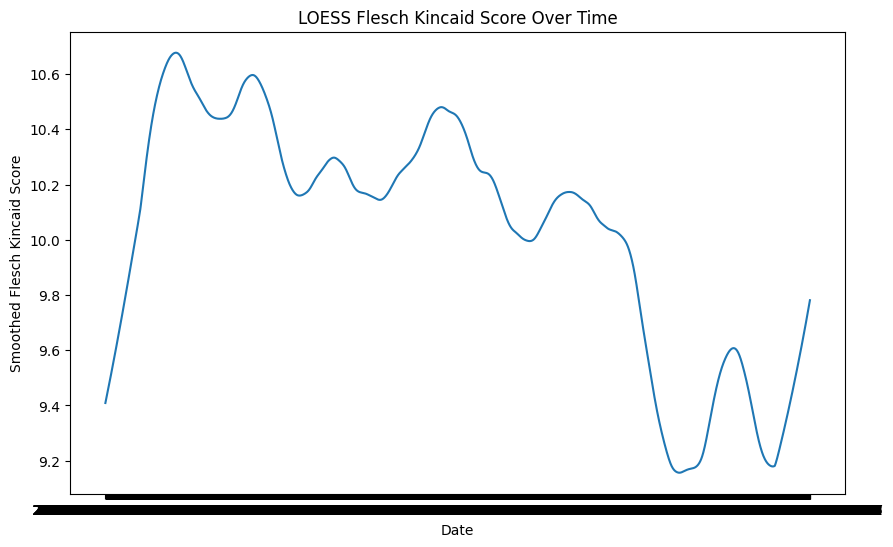

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
# Apply LOESS smoothing
lowess = sm.nonparametric.lowess(df_flesch_kincaid['flesch_kincaid'], df_flesch_kincaid.index, frac=0.1)

plt.figure(figsize=(10, 6))
plt.plot(df_flesch_kincaid['date'], lowess[:, 1])
plt.xlabel('Date')
plt.ylabel('Smoothed Flesch Kincaid Score')
plt.title('LOESS Flesch Kincaid Score Over Time')
plt.show()

## Plot Dale Chall

In [ ]:
df_dale_chall = df_readability_kickstarter_small.groupby('date')['dale_chall'].mean().reset_index()

In [ ]:
df_dale_chall = df_dale_chall.sort_values('date')

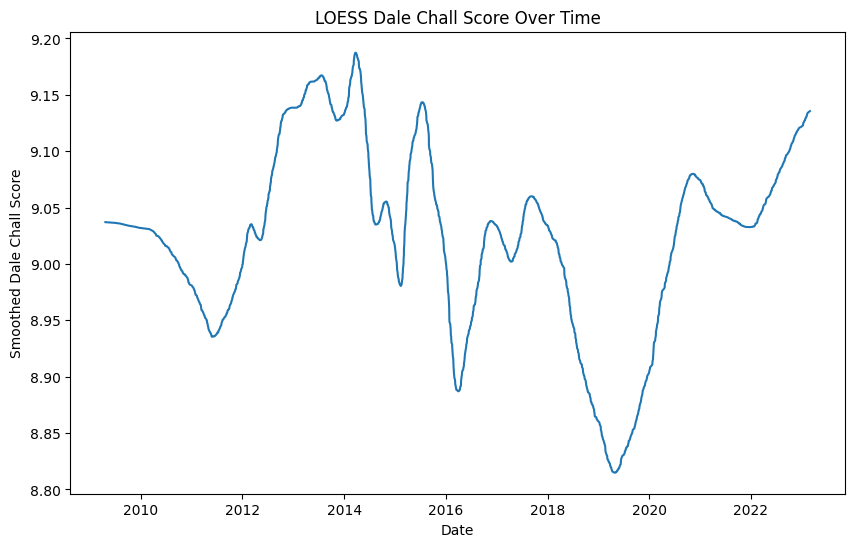

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
# Apply LOESS smoothing
lowess = sm.nonparametric.lowess(df_dale_chall['dale_chall'], df_dale_chall.index, frac=0.1)

plt.figure(figsize=(10, 6))
plt.plot(df_dale_chall['date'], lowess[:, 1])
plt.xlabel('Date')
plt.ylabel('Smoothed Dale Chall Score')
plt.title('LOESS Dale Chall Score Over Time')
plt.show()

## Plot Ari

In [ ]:
df_ari = df_readability_kickstarter_small.groupby('date')['ari'].mean().reset_index()

In [ ]:
df_ari = df_ari.sort_values('date')

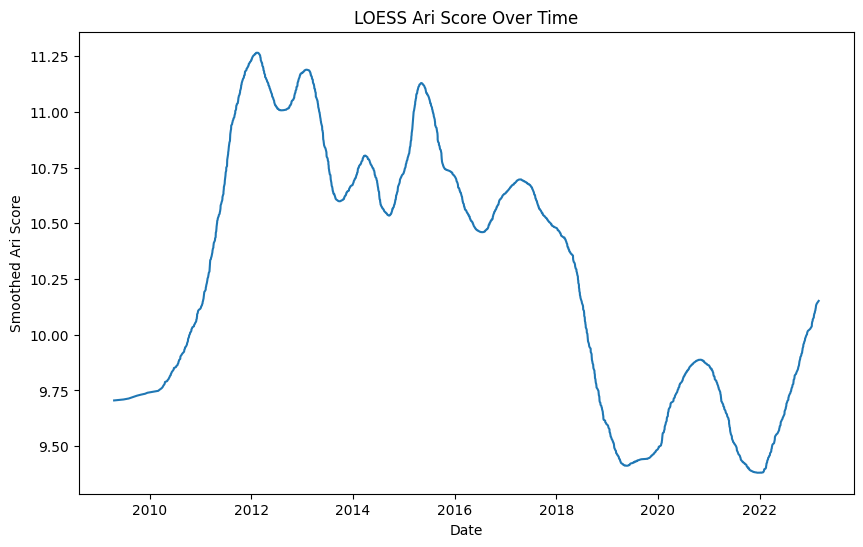

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
# Apply LOESS smoothing
lowess = sm.nonparametric.lowess(df_ari['ari'], df_ari.index, frac=0.1)

plt.figure(figsize=(10, 6))
plt.plot(df_ari['date'], lowess[:, 1])
plt.xlabel('Date')
plt.ylabel('Smoothed Ari Score')
plt.title('LOESS Ari Score Over Time')
plt.show()

## Plot Coleman Liau

In [ ]:
df_coleman_liau = df_readability_kickstarter_small.groupby('date')['coleman_liau'].mean().reset_index()

In [ ]:
df_coleman_liau = df_coleman_liau.sort_values('date')

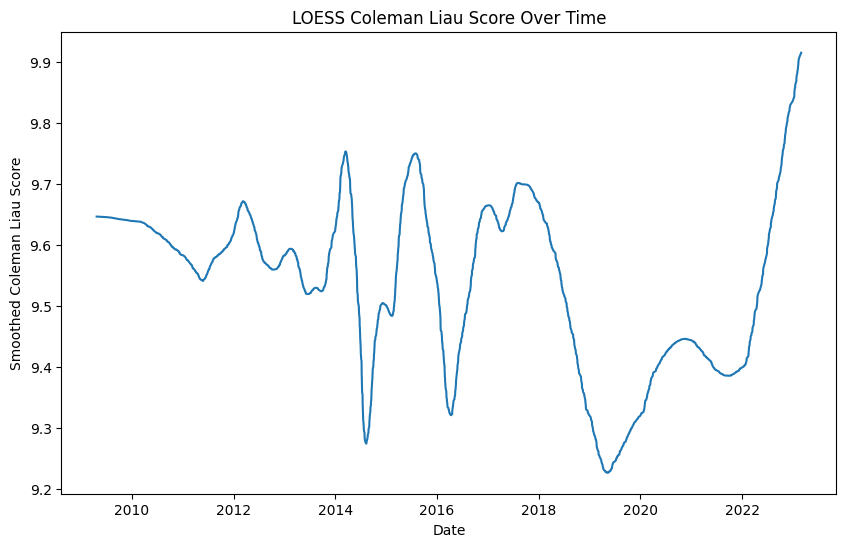

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
# Apply LOESS smoothing
lowess = sm.nonparametric.lowess(df_coleman_liau['coleman_liau'], df_coleman_liau.index, frac=0.1)

plt.figure(figsize=(10, 6))
plt.plot(df_coleman_liau['date'], lowess[:, 1])
plt.xlabel('Date')
plt.ylabel('Smoothed Coleman Liau Score')
plt.title('LOESS Coleman Liau Score Over Time')
plt.show()

## Plot Gunning Fog

In [ ]:
df_gunning_fog = df_readability_kickstarter_small.groupby('date')['gunning_fog'].mean().reset_index()

In [ ]:
df_gunning_fog = df_gunning_fog.sort_values('date')

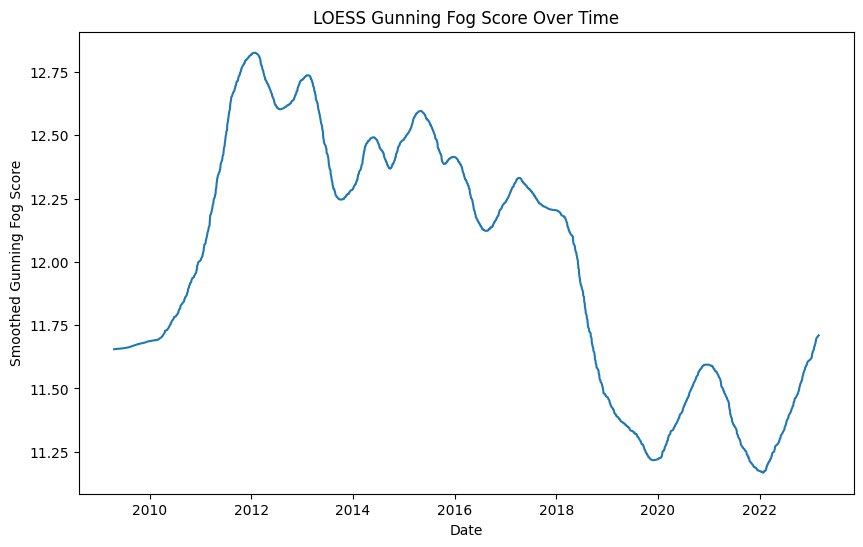

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
# Apply LOESS smoothing
lowess = sm.nonparametric.lowess(df_gunning_fog['gunning_fog'], df_gunning_fog.index, frac=0.1)

plt.figure(figsize=(10, 6))
plt.plot(df_gunning_fog['date'], lowess[:, 1])
plt.xlabel('Date')
plt.ylabel('Smoothed Gunning Fog Score')
plt.title('LOESS Gunning Fog Score Over Time')
plt.show()

## Plot Spache

In [ ]:
df_spache = df_readability_kickstarter_small.groupby('date')['spache'].mean().reset_index()

In [ ]:
df_spache = df_spache.sort_values('date')

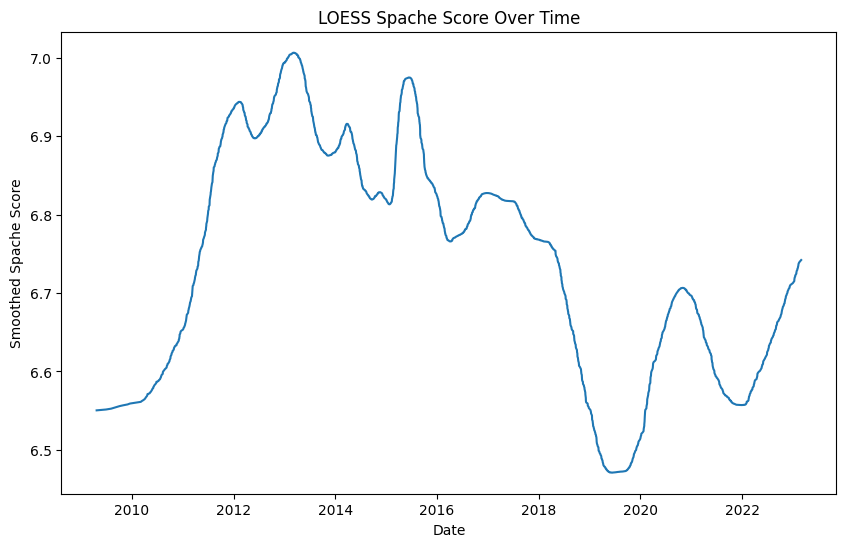

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
# Apply LOESS smoothing
lowess = sm.nonparametric.lowess(df_spache['spache'], df_spache.index, frac=0.1)

plt.figure(figsize=(10, 6))
plt.plot(df_spache['date'], lowess[:, 1])
plt.xlabel('Date')
plt.ylabel('Smoothed Spache Score')
plt.title('LOESS Spache Score Over Time')
plt.show()

# OLS Models

In [63]:
#!pip install statsmodels
import numpy as np
import statsmodels.api as sm
from datetime import datetime

In [64]:
# Setting up Model Variables by transforming Data Columns

## Sorting by Date and other Date transformations
df_readability_kickstarter_small['project_launched_at'] = pd.to_datetime(df_readability_kickstarter_small['project_launched_at'])
df_readability_kickstarter_small.sort_values(by='project_launched_at', inplace=True)

df_readability_kickstarter_small['project_deadline'] = pd.to_datetime(df_readability_kickstarter_small['project_deadline'])
df_readability_kickstarter_small['timestamp_launched'] = df_readability_kickstarter_small['project_launched_at'].apply(lambda x: (datetime.timestamp(x) / 1000000))
df_readability_kickstarter_small['timestamp_deadline'] = df_readability_kickstarter_small['project_deadline'].apply(lambda x: (datetime.timestamp(x) / 1000000))

## Response Variable
CF_success = df_readability_kickstarter_small['project_pledged'].apply(lambda x: np.log(x) if x != 0 else 0)

## Explanatory Variables
readability = df_readability_kickstarter_small['flesch_kincaid']
readability_squared = df_readability_kickstarter_small['flesch_kincaid'] * df_readability_kickstarter_small['flesch_kincaid']
time = df_readability_kickstarter_small['timestamp_launched']
readabilityXtime = readability * time
readability_squaredXtime = readability_squared * time
bertscore = df_readability_kickstarter_small['bert_score']
bertscoreXtime = bertscore * time

##Control Variables
loved_project = df_readability_kickstarter_small['project_staff_pick']
video = df_readability_kickstarter_small['project_video_url'].apply(lambda x: 0 if pd.isna(x) else 1)
funding_duration = df_readability_kickstarter_small['timestamp_deadline'] - df_readability_kickstarter_small['timestamp_launched']
number_of_words = df_readability_kickstarter_small['num_words']
log_funding_goal = df_readability_kickstarter_small['project_goal'].apply(lambda x: np.log(x))
updates = df_readability_kickstarter_small['updates_until_deadline']
rewards = df_readability_kickstarter_small['project_rewards']
number_projects = df_readability_kickstarter_small['project_creator_project_number'].apply(lambda x: 0 if pd.isna(x) else x)

## Flesch-Kincaid no time

In [ ]:
# Create a new DataFrame to store the variables
df_model = pd.DataFrame({
    'Readability': readability,
    #'Time': time,
    #'Readability * Time': readabilityXtime,
    'Loved Project': loved_project,
    'Video': video,
    'Funding Duration': funding_duration,
    'Number of Words': number_of_words,
    'Log(Funding Goal)': log_funding_goal,
    'Updates': updates,
    'Rewards': rewards
})
X = df_model
# Add a constant (intercept) to the feature matrix
X_with_intercept = sm.add_constant(X)

# Fit for model without time
model = sm.OLS(CF_success, X_with_intercept, 'raise').fit()

# Print the summary of the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        project_pledged   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     286.9
Date:                Wed, 02 Aug 2023   Prob (F-statistic):               0.00
Time:                        21:03:48   Log-Likelihood:                -8137.6
No. Observations:                3531   AIC:                         1.629e+04
Df Residuals:                    3522   BIC:                         1.635e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.1387      0.24

## Flesch-Kincaid with time

In [ ]:
# Create a new DataFrame to store the variables
df_model_time = pd.DataFrame({
    'Readability': readability,
    'Time': time,
    'Readability * Time': readabilityXtime,
    'Loved Project': loved_project,
    'Video': video,
    'Funding Duration': funding_duration,
    'Number of Words': number_of_words,
    'Log(Funding Goal)': log_funding_goal,
    'Updates': updates,
    'Rewards': rewards
})
X_time = df_model_time
# Add a constant (intercept) to the feature matrix
X_with_intercept_time = sm.add_constant(X_time)

# Fit for model with time
model_tvcr = sm.OLS(CF_success, X_with_intercept_time, 'raise').fit()

# Print the summary of the regression results
print(model_tvcr.summary())

                            OLS Regression Results                            
Dep. Variable:        project_pledged   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     234.5
Date:                Wed, 02 Aug 2023   Prob (F-statistic):               0.00
Time:                        21:05:01   Log-Likelihood:                -8121.9
No. Observations:                3531   AIC:                         1.627e+04
Df Residuals:                    3520   BIC:                         1.633e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.3641      1

In [ ]:
fig = sm.graphics.influence_plot(model_tvcr, criterion="DFFITS")
fig.tight_layout(pad=1.0)

In [ ]:
fig = sm.graphics.plot_regress_exog(model_tvcr, "Readability")
fig.tight_layout(pad=1.0)

## Flesch-Kincaid Squared no time

In [ ]:
# Create a new DataFrame to store the variables
df_model_squared = pd.DataFrame({
    'Readability': readability,
    'Readability^2': readability_squared,
    #'Time': time,
    #'Readability * Time': readabilityXtime,
    'Loved Project': loved_project,
    'Video': video,
    'Funding Duration': funding_duration,
    'Number of Words': number_of_words,
    'Log(Funding Goal)': log_funding_goal,
    'Updates': updates,
    'Rewards': rewards,
    'Number of projects': number_projects
})
X_squared = df_model_squared
# Add a constant (intercept) to the feature matrix
X_squared_with_intercept = sm.add_constant(X_squared)

# Fit for model without time
model_squared = sm.OLS(CF_success, X_squared_with_intercept, 'raise').fit()

# Print the summary of the regression results
print(model_squared.summary())

                            OLS Regression Results                            
Dep. Variable:        project_pledged   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     236.6
Date:                Sat, 05 Aug 2023   Prob (F-statistic):               0.00
Time:                        15:53:41   Log-Likelihood:                -8115.9
No. Observations:                3531   AIC:                         1.625e+04
Df Residuals:                    3520   BIC:                         1.632e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.5655      0

## Flesch-Kincaid Squared with time

In [70]:
# Create a new DataFrame to store the variables
df_model_squared_time = pd.DataFrame({
    #'Readability': readability,
    #'Readability^2': readability_squared,
    'Time': time,
    #'Readability * Time': readabilityXtime,
    'Bert Score': bertscore,
    'Bert Score * Time': bertscoreXtime,
    #'Readability^2 * Time': readability_squaredXtime,
    'Loved Project': loved_project,
    'Video': video,
    'Funding Duration': funding_duration,
    'Number of Words': number_of_words,
    'Log(Funding Goal)': log_funding_goal,
    'Updates': updates,
    'Rewards': rewards,
    'Number of projects': number_projects
})
X_squared_time = df_model_squared_time
# Add a constant (intercept) to the feature matrix
X_squared_time_with_intercept = sm.add_constant(X_squared_time)

# Fit for model without time
model_squared_time = sm.OLS(CF_success, X_squared_time_with_intercept, 'raise').fit()

# Print the summary of the regression results
print(model_squared_time.summary())

                            OLS Regression Results                            
Dep. Variable:        project_pledged   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     220.1
Date:                Sat, 02 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:02:13   Log-Likelihood:                -8099.1
No. Observations:                3531   AIC:                         1.622e+04
Df Residuals:                    3519   BIC:                         1.630e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  4.4478      1

In [67]:
cls = LinearRegDiagnostic(model_squared_time)

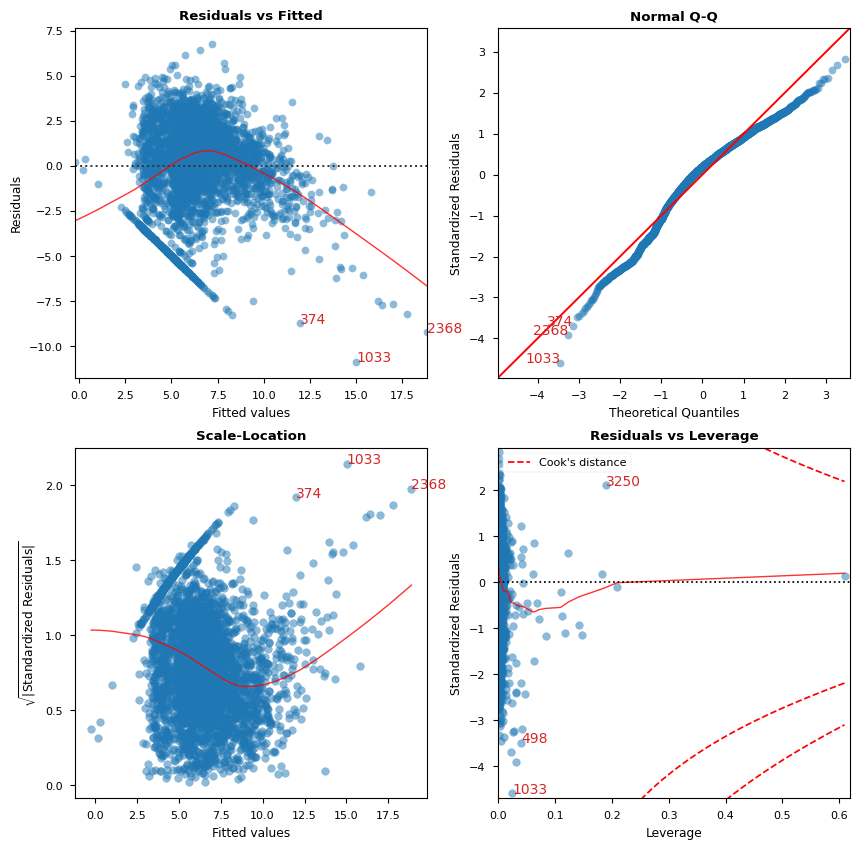

              Features  VIF Factor
9     Funding Duration        1.09
14  Number of projects        1.09
7        Loved Project        1.10
8                Video        1.14
11   Log(Funding Goal)        1.17
12             Updates        1.27
13             Rewards        1.31
10     Number of Words        1.36
2        Readability^2        3.59
3                 Time       12.38
4   Readability * Time      284.69
1          Readability      293.42
5           Bert Score      302.29
6    Bert Score * Time      310.62
0                const     2591.86


In [68]:
vif, fig, ax = cls()
print(vif)

# State Space KTR-Model

In [8]:
!pip install orbit-ml
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import orbit
from orbit.models import KTR
from orbit.diagnostics.plot import plot_predicted_components
from orbit.utils.plot import get_orbit_style
from orbit.constants.palette import OrbitPalette

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.9/445.9 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 39.8 MB/s eta 0:00:00
  Created wheel for orbit-ml: filename=orbit_ml-1.1.4.2-py3-none-any.whl size=475070 sha256=e4b28eece04d4ebdd1f92da8d72b69e1296cb9145fdc90d45a71da245e8c28d3
  Stored in directory: /root/.cache/pip/wheels/d6/d5/12/29fb5179003c5899b3a9281d268f9579df35bb263b985c6456
Successfully built orbit-ml


In [8]:
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.5f' % x)
orbit_style = get_orbit_style()
plt.style.use(orbit_style);

In [10]:
# Setting up Model Variables by transforming Data Columns

## Sorting by Date and other Date transformations
df_readability_kickstarter_small['project_launched_at'] = pd.to_datetime(df_readability_kickstarter_small['project_launched_at'])
df_readability_kickstarter_small.sort_values(by='project_launched_at', inplace=True)

df_readability_kickstarter_small['project_deadline'] = pd.to_datetime(df_readability_kickstarter_small['project_deadline'])
df_readability_kickstarter_small['timestamp_launched'] = df_readability_kickstarter_small['project_launched_at'].apply(lambda x: (datetime.timestamp(x) / 1000000))
df_readability_kickstarter_small['timestamp_deadline'] = df_readability_kickstarter_small['project_deadline'].apply(lambda x: (datetime.timestamp(x) / 1000000))

## Response Variable
CF_success = df_readability_kickstarter_small['project_pledged'].apply(lambda x: np.log(x) if x != 0 else 0)

## Explanatory Variables
readability = df_readability_kickstarter_small['flesch_kincaid']
readability_squared = df_readability_kickstarter_small['flesch_kincaid'] * df_readability_kickstarter_small['flesch_kincaid']

##Control Variables
loved_project = df_readability_kickstarter_small['project_staff_pick']
video = df_readability_kickstarter_small['project_video_url'].apply(lambda x: 0 if pd.isna(x) else 1)
funding_duration = df_readability_kickstarter_small['timestamp_deadline'] - df_readability_kickstarter_small['timestamp_launched']
number_of_words = df_readability_kickstarter_small['num_words']
log_funding_goal = df_readability_kickstarter_small['project_goal'].apply(lambda x: np.log(x))
updates = df_readability_kickstarter_small['updates_until_deadline']
rewards = df_readability_kickstarter_small['project_rewards']
number_projects = df_readability_kickstarter_small['project_creator_project_number'].apply(lambda x: 0 if pd.isna(x) else x)

In [24]:
# Create a new DataFrame to store the variables
df_stochastic = pd.DataFrame({
    'Crowdfunding success': CF_success,
    'Readability': readability,
    'Readability^2': readability_squared,
    #'Time': time,
    #'Readability * Time': readabilityXtime,
    #'Readability^2 * Time': readability_squaredXtime,
    'Loved Project': loved_project,
    'Video': video,
    'Funding Duration': funding_duration,
    'Number of Words': number_of_words,
    'Log(Funding Goal)': log_funding_goal,
    'Updates': updates,
    'Rewards': rewards,
    'Number of projects': number_projects,
    'date': df_readability_kickstarter_small['project_launched_at']
})

In [25]:
regressor_col = ['Readability', 'Readability^2', 'Loved Project', 'Video', 'Funding Duration', 'Number of Words',
                  'Log(Funding Goal)', 'Updates', 'Rewards', 'Number of projects']
response_col = 'Crowdfunding success'
date_col='date'

In [26]:
ktr = KTR(
    response_col=response_col,
    date_col=date_col,
    regressor_col=regressor_col,
    prediction_percentiles=[2.5, 97.5],
    seed=2013,
    estimator='pyro-svi',
)

In [27]:
ktr.fit(df=df_stochastic)
ktr.predict(df=df_stochastic, decompose=True).head(5)

/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:288: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")
2023-08-10 21:21:53 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:288: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")
2023-08-10 21:21:53 - orbit - INFO - First time in running stan model:ktrlite. Expect 3 - 5 minutes for compilation.
INFO:orbit:First time in running stan model:ktrlite. Expect 3 - 5 minutes for compilation.
2023-08-10 21:22:35 - orbit - INFO - Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
INFO:orbit:Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particle

,date,prediction_2.5,prediction,prediction_97.5,trend_2.5,trend,trend_97.5,regression_2.5,regression,regression_97.5
0,2009-04-21 21:02:48,-3.82303,3.25590,8.51390,-0.29206,6.52060,11.90857,-4.09634,-3.50050,-2.69549
1,2009-06-28 06:53:01,-5.28190,0.59951,6.33435,0.63062,6.38584,11.64898,-6.61376,-5.68887,-4.75438
2,2009-08-04 02:46:44,-4.69065,0.13708,6.77137,1.05627,6.20982,12.81267,-7.63221,-6.12858,-4.58942
3,2009-08-23 19:02:36,-4.53139,0.61924,6.22574,1.85867,7.16687,12.25644,-7.50784,-6.57842,-5.47738
4,2009-09-14 19:40:13,-3.50456,1.98323,10.07441,0.42773,5.88235,12.67932,-5.27865,-3.56735,-1.74815


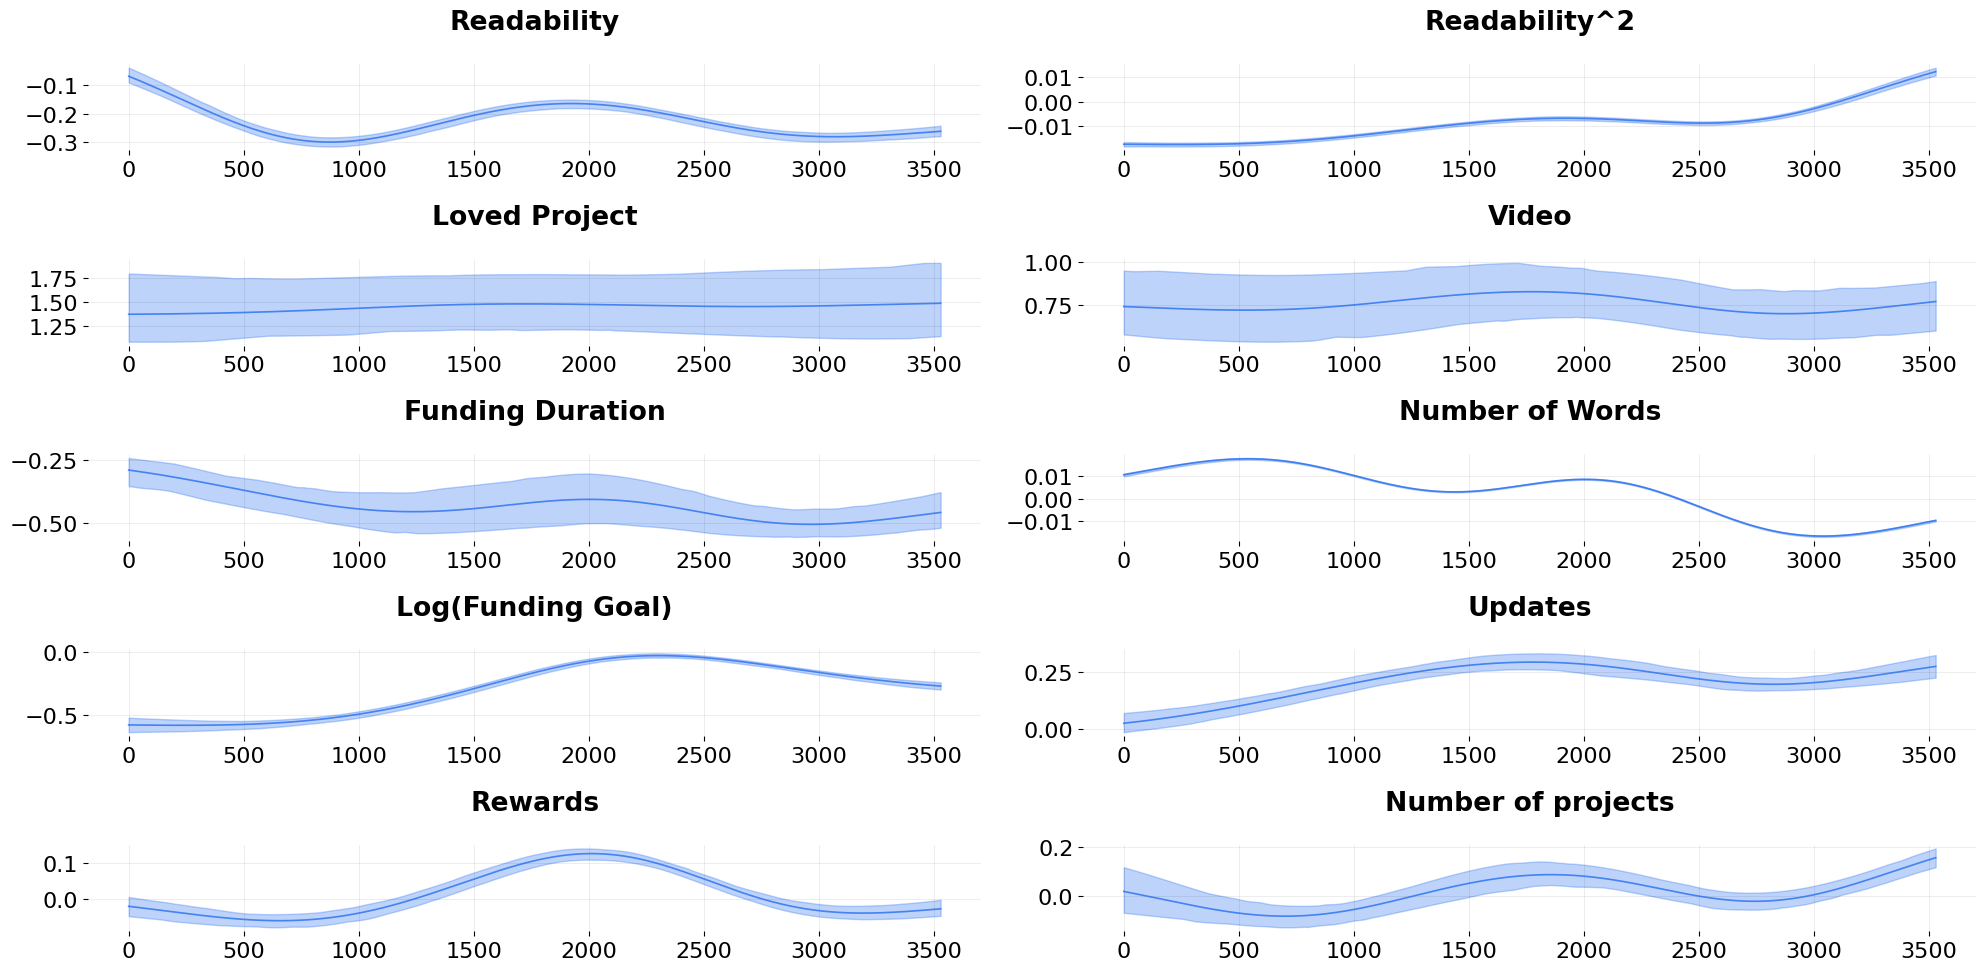

In [30]:
ktr.plot_regression_coefs(figsize=(20, 10), include_ci=True);